In [3]:
import pandas as pd

arima_rmse = 1562.26
arima_mape = 29.90
best_rf_rmse = 299.46
best_rf_mape = 5.95
hybrid_rmse = 702.84
hybrid_mape = 13.47

metrics = pd.DataFrame({
    'Model': ['ARIMA', 'Tuned Random Forest', 'Hybrid Model'],
    'RMSE': [arima_rmse, best_rf_rmse, hybrid_rmse],
    'MAPE (%)': [arima_mape, best_rf_mape, hybrid_mape]
})

display(metrics)


,Model,RMSE,MAPE (%)
0,ARIMA,1562.26,29.90
1,Tuned Random Forest,299.46,5.95
2,Hybrid Model,702.84,13.47


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

df = pd.read_csv('../data/raw/daily-website-visitors.csv', parse_dates=['Date'])

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

numeric_columns = ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']
for col in numeric_columns:
    df[col] = df[col].str.replace(',', '').astype(int)

df['Year'] = df.index.year
df['Month'] = df.index.month
df['Week'] = df.index.isocalendar().week
df['Day'] = df.index.day
df['Day_Of_Week'] = df.index.dayofweek  # Monday=0, Sunday=6
df['Is_Weekend'] = (df['Day_Of_Week'] >= 5).astype(int)

df['Lag_1'] = df['Page.Loads'].shift(1)
df['Lag_7'] = df['Page.Loads'].shift(7)
df['Rolling_Mean_7'] = df['Page.Loads'].rolling(window=7).mean()

df.dropna(inplace=True)

split_point = int(len(df) * 0.8)
train = df.iloc[:split_point]
test = df.iloc[split_point:]

train_series = train['Page.Loads']
test_series = test['Page.Loads']

arima_model = ARIMA(train_series, order=(1, 1, 1))
arima_fit = arima_model.fit()
forecast = arima_fit.forecast(steps=len(test_series))

features = ['Unique.Visits', 'First.Time.Visits', 'Returning.Visits', 
            'Day_Of_Week', 'Is_Weekend', 'Lag_1', 'Lag_7', 'Rolling_Mean_7']
target = 'Page.Loads'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

print("Re-run modeling code completed. Variables 'forecast', 'test_series', and 'rf_predictions' are now available.")


c:\Users\KSCOM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\KSCOM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\KSCOM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Re-run modeling code completed. Variables 'forecast', 'test_series', and 'rf_predictions' are now available.


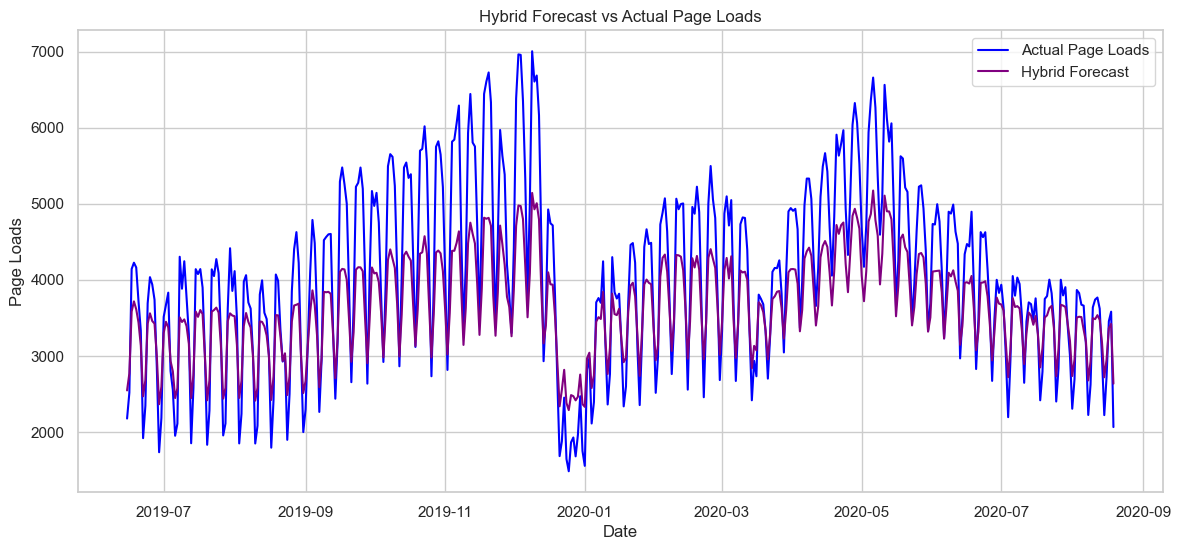

In [7]:
hybrid_forecast = (forecast.values + rf_predictions) / 2

plt.figure(figsize=(14, 6))
plt.plot(test_series.index, test_series, label='Actual Page Loads', color='blue')
plt.plot(test_series.index, hybrid_forecast, label='Hybrid Forecast', color='purple')
plt.title('Hybrid Forecast vs Actual Page Loads')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.show()
